### End-to-end SSL stepcounter training with OxWalk

This notebook trains the stepcounter that was used in:

Small SR, Chan S, Walmsley R, et al. (2023)
[Development and Validation of a Machine Learning Wrist-worn Step Detection Algorithm with Deployment in the UK Biobank](https://www.medrxiv.org/content/10.1101/2023.02.20.23285750v1).
medRxiv. DOI: 10.1101/2023.02.20.23285750

This notebook has been modified to run on Dr. Keadle's Cal Poly ACT24 data.

Original notebook can be found [here](https://github.com/OxWearables/stepcount/blob/main/train-ssl.ipynb).

## Imports

In [1]:
import re
import glob
import os
import numpy as np
import pandas as pd
import pathlib
import torch
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed

Check torch version and to see if GPU acceleration is available.

This notebook was originally run on torch version 2.2.2+cu121, with GPU acceleration.

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

2.2.2+cu121
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Data processing

Below are functions to load the data, adapted from the original functions provided by UK Biobank. Requires the following files:
- ACT24_Apr2024 directory, with ACT24_###_#_SSL.csv files created by the DATA 2024 team. ### is the id, # is the observation.

In [3]:
DATA_DIR = 'ACT24_Apr2024'  # location of data (the ACT24_###_#_SSL.csv files should be in this folder)
DATAFILES = os.path.join(DATA_DIR, 'ACT24_*.csv')
OUT_DIR = './data/act24_80hz_5/'  # output location of the processed dataset
WINDOW_SEC = 10  # seconds
STEP_THRESHOLD = 4  # how many steps per window to consider a step (equal or more). This is not used in this notebook but is kept as a placeholder

DEVICE_HZ = 80  # original sample rate Hz
RESAMPLE_HZ = 30  # Hz
WINDOW_OVERLAP_SEC = 0  # seconds
WINDOW_LEN = int(DEVICE_HZ * WINDOW_SEC)  # device ticks
WINDOW_OVERLAP_LEN = int(DEVICE_HZ * WINDOW_OVERLAP_SEC)  # device ticks
WINDOW_STEP_LEN = WINDOW_LEN - WINDOW_OVERLAP_LEN  # device ticks
WINDOW_TOL = 0.01  # 1%


def resize(x, length, axis=1):
    """Resize the temporal length using linear interpolation.
    X must be of shape (N,M,C) (channels last) or (N,C,M) (channels first),
    where N is the batch size, M is the temporal length, and C is the number
    of channels.
    If X is channels-last, use axis=1 (default).
    If X is channels-first, use axis=2.
    """
    from scipy.interpolate import interp1d

    length_orig = x.shape[axis]
    t_orig = np.linspace(0, 1, length_orig, endpoint=True)
    t_new = np.linspace(0, 1, length, endpoint=True)
    x = interp1d(t_orig, x, kind="linear", axis=axis, assume_sorted=True)(
        t_new
    )
    return x


def is_good_quality(w):
    """ Window quality check """

    if w.isna().any().any():
        return False

    if len(w) != WINDOW_LEN:
        return False

    w_start, w_end = w.index[0], w.index[-1]
    w_duration = w_end - w_start
    target_duration = pd.Timedelta(WINDOW_SEC, 's')
    if np.abs(w_duration - target_duration) > WINDOW_TOL * target_duration:
        return False

    return True


def make(datafile):
    X, Y, T, P, = [], [], [], []
    y_step = []

    data = pd.read_csv(datafile, parse_dates=['timestamp'], index_col='timestamp')

    p = re.search(r'(ACT24_\d{3}_\d{1})', datafile, flags=re.IGNORECASE).group()

    for i in range(0, len(data), WINDOW_STEP_LEN):
        w = data.iloc[i:i + WINDOW_LEN]
        postures = w['posture'].mode()

        if not is_good_quality(w) or "private/not coded" in list(postures):
            continue

        t = w.index[0].to_datetime64()
        x = w[['x', 'y', 'z']].values
        posture = postures.sample(n=1).iloc[0]
        # count = int(w['annotation'].sum())
        count = int(w['step'].sum())
        y = posture

        X.append(x)
        Y.append(y)
        T.append(t)
        P.append(p)
        y_step.append(count)

    X = np.asarray(X)
    Y = np.asarray(Y)
    T = np.asarray(T)
    P = np.asarray(P)
    y_step = np.asarray(y_step)

    if DEVICE_HZ != RESAMPLE_HZ:
        X = resize(X, int(RESAMPLE_HZ * WINDOW_SEC))

    return X, Y, T, P, y_step

Convert the raw data into 10s windowed data X at 30Hz, with step count annotations Y_step and group labels groups. A categorical array Y is also generated. Save to disk for later reuse. **This means that the code in this section only needs to be run once!**

In [4]:
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

with Parallel(n_jobs=4, prefer="threads") as parallel:
    results = parallel(delayed(make)(datafile) for datafile in tqdm(glob.glob(DATAFILES)))

x, y, t, p, y_step = zip(*results)

X = np.vstack(x)  # data windows
Y = np.hstack(y)  # binary labels walk/notwalk (based on Y_step >= STEP_THRESHOLD)
Y_step = np.hstack(y_step)  # step counts per window
T = np.hstack(t)  # timestamps
groups = np.hstack(p)  # group ids

np.save(os.path.join(OUT_DIR, 'X'), X)
np.save(os.path.join(OUT_DIR, 'Y'), Y)
np.save(os.path.join(OUT_DIR, 'time'), T)
np.save(os.path.join(OUT_DIR, 'groups'), groups)
np.save(os.path.join(OUT_DIR, 'Y_step'), Y_step)

print(f"Saved in {OUT_DIR}")
print("X shape:", X.shape)
print("Y distribution:")
print(pd.Series(Y).value_counts())

100%|██████████| 32/32 [01:51<00:00,  3.48s/it]


Saved in ./data/act24_80hz_5/
X shape: (32640, 300, 3)
Y distribution:
sitting                 16318
stand                    7564
walk                     3160
stand and move           2896
walk with load            784
lying                     668
kneeling/ squatting       331
stretching                293
bike                      263
ascend stairs             171
muscle strengthening       94
descend stairs             57
other sport movement       40
running                     1
Name: count, dtype: int64


## Load data from disk

The oxwearables activity classifier can only use numeric input, so below we create mappings to convert the posture categorical labels to numbers and back.

In [4]:
posture_to_num = {"sitting": 0, "stand": 1, "walk": 2, "stand and move": 3, "walk with load": 4, "lying": 5, "kneeling/ squatting": 6, "stretching": 7, "bike": 8, "ascend stairs": 9, "muscle strengthening": 10, "descend stairs": 11, "other sport movement": 12, "running": 13}
num_to_posture = {0: "sitting", 1: "stand", 2: "walk", 3: "stand and move", 4: "walk with load", 5: "lying", 6: "kneeling/ squatting", 7: "stretching", 8: "bike", 9: "ascend stairs", 10: "muscle strengthening", 11: "descend stairs", 12: "other sport movement", 13: "running"}

Load data from disk. This is what was saved in the previous section. Note that the postures have been converted to numbers.

In [5]:
path = './data/act24_80hz/'

X = np.load(path + 'X.npy')
Y_step = np.load(path + 'Y_step.npy')
Y = pd.Series(np.load(path + 'Y.npy')).map(posture_to_num).to_numpy()
groups = np.load(path + 'groups.npy')
T = np.load(path + 'time.npy')

In [6]:
pd.Series(Y).value_counts(normalize=True)

0     0.500184
1     0.231710
2     0.096538
3     0.088817
4     0.023958
5     0.020435
6     0.009988
7     0.009007
8     0.008027
9     0.005270
10    0.002941
11    0.001808
12    0.001287
13    0.000031
Name: proportion, dtype: float64

## Posture classifier NN code

Below is the neural network that classifies posture, modified to classify more postures as they appear in the ACT24 dataset.

The stepcount dependencies can be downloaded here, if there are any errors in loading the package with pip:
- <https://github.com/OxWearables/stepcount/tree/main/src/stepcount>

In [ ]:
# Modified from stepcount.hmm_utils
from pathlib import Path
import torch.nn as nn

verbose = True
torch_cache_path = Path('stepcount/torch_hub_cache')

torch.multiprocessing.set_sharing_strategy('file_system')

def get_sslnet(tag='v1.0.0', pretrained=False, class_num=10):
    """
    Load and return the Self Supervised Learning (SSL) model from pytorch hub.

    :param str tag: Tag on the ssl-wearables repo to check out
    :param bool pretrained: Initialise the model with UKB self-supervised pretrained weights.
    :return: pytorch SSL model
    :rtype: nn.Module
    """

    repo_name = 'ssl-wearables'
    repo = f'OxWearables/{repo_name}:{tag}'

    if not torch_cache_path.exists():
        Path.mkdir(torch_cache_path, parents=True, exist_ok=True)

    torch.hub.set_dir(str(torch_cache_path))

    # find repo cache dir that matches repo name and tag
    cache_dirs = [f for f in torch_cache_path.iterdir() if f.is_dir()]
    repo_path = next((f for f in cache_dirs if repo_name in f.name and tag in f.name), None)

    if repo_path is None:
        repo_path = repo
        source = 'github'
    else:
        repo_path = str(repo_path)
        source = 'local'
        if verbose:
            print(f'Using local {repo_path}')

    sslnet: nn.Module = torch.hub.load(repo_path, 'harnet10', trust_repo=True, source=source, class_num=class_num,
                                       pretrained=pretrained, verbose=verbose)
    return sslnet

In [10]:
import torch
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn.model_selection import GroupShuffleSplit
from stepcount import hmm_utils
from stepcount import sslmodel
from torch.utils.data import DataLoader

from sklearn.utils.class_weight import compute_class_weight

class WalkDetectorSSL:
    def __init__(
            self,
            device='cpu',
            batch_size=100,
            weights_path='state_dict.pt',
            repo_tag='v1.0.0',
            hmm_params=None,
            verbose=False,
    ):
        self.device = device
        self.weights_path = weights_path
        self.repo_tag = repo_tag
        self.batch_size = batch_size
        self.state_dict = None

        self.verbose = verbose

        hmm_params = hmm_params or dict()
        self.hmms = hmm_utils.HMMSmoother(**hmm_params)

    def fit(self, X, Y, groups=None):
        sslmodel.verbose = self.verbose

        if self.verbose:
            print('Training SSL')

        # prepare training and validation sets
        folds = GroupShuffleSplit(
            1, test_size=0.2, random_state=41
        ).split(X, Y, groups=groups)
        train_idx, val_idx = next(folds)

        x_train = X[train_idx]
        x_val = X[val_idx]

        y_train = Y[train_idx]
        y_val = Y[val_idx]

        group_train = groups[train_idx]
        group_val = groups[val_idx]

        train_dataset = sslmodel.NormalDataset(x_train, y_train, pid=group_train, name="training", augmentation=True)
        val_dataset = sslmodel.NormalDataset(x_val, y_val, pid=group_val, name="validation")

        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=1,
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=1,
        )

        # balancing to 90% notwalk, 10% walk
        class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y).tolist()

        model = get_sslnet(tag=self.repo_tag, pretrained=True, class_num=len(np.unique(Y)))
        model.to(self.device)

        sslmodel.train(model, train_loader, val_loader, self.device,
                       class_weights, weights_path=self.weights_path)
        model.load_state_dict(torch.load(self.weights_path, self.device))

        if self.verbose:
            print('Training HMM')

        # train HMM with predictions of the validation set
        y_val, y_val_pred, group_val = sslmodel.predict(model, val_loader,
                                                        self.device,
                                                        output_logits=True)
        y_val_pred_sf = softmax(y_val_pred, axis=1)

        self.hmms.fit(y_val_pred_sf, y_val, groups=group_val)

        # move model to cpu to get a device-less state dict (prevents device conflicts when loading on cpu/gpu later)
        model.to('cpu')
        self.state_dict = model.state_dict()

        return self

    def predict(self, X, class_num, groups=None):
        sslmodel.verbose = self.verbose

        dataset = sslmodel.NormalDataset(X, name='prediction')
        dataloader = DataLoader(
            dataset,
            batch_size=512,
            shuffle=False,
            num_workers=0,
        )

        model = sslmodel.get_sslnet(tag=self.repo_tag, pretrained=False, class_num=class_num)
        model.load_state_dict(self.state_dict)
        model.to(self.device)

        _, y_pred, _ = sslmodel.predict(model, dataloader, self.device, output_logits=False)

        y_pred = self.hmms.predict(y_pred, groups=groups)

        return y_pred

## Leave One Individual Out Cross Validation

In [8]:
from stepcount.models import toV, calc_sample_weight, batch_count_peaks_from_V
from sklearn import metrics
from scipy.optimize import minimize

In [11]:
indvs = pd.Series(groups).str.split("_").apply(lambda x: int(x[1])).to_numpy()
groups_validation = pd.Series()
steps_validation = pd.Series()
postures_validation = pd.Series()

sample_rate = 30
lowpass_hz = 5
pnr = 1.0

unique_indvs = np.unique(indvs)
n_unique_indvs = str(len(unique_indvs))
indvs_idx = 0
first_occur = [np.where(Y == value)[0][0] for value in np.unique(Y)]

for indv in unique_indvs:
    indvs_idx += 1
    print("Processing " + str(indvs_idx) + "/" + n_unique_indvs)
    
    X_test = X[indvs == indv]
    X_train = np.concatenate([X[indvs != indv], X[first_occur]])
    # X_train = X[indvs != indv]
    Y_test = Y[indvs == indv]
    Y_train = np.concatenate([Y[indvs != indv], Y[first_occur]])
    # Y_train = Y[indvs != indv]
    Y_step_test = Y_step[indvs == indv]
    Y_step_train = np.concatenate([Y_step[indvs != indv], Y_step[first_occur]])
    # Y_step_train = Y_step[indvs != indv]
    groups_test = groups[indvs == indv]
    groups_train = np.concatenate([groups[indvs != indv], groups[first_occur]])
    # groups_train = groups[indvs != indv]
    T_test = T[indvs == indv]
    T_train = np.concatenate([T[indvs != indv], T[first_occur]])
    # T_train = T[indvs != indv]
    
    wd = WalkDetectorSSL(
        device='cuda' if torch.cuda.is_available() else 'cpu',
        batch_size=512,
        verbose=True
    )
    wd.fit(X_train, Y_train, groups_train)
    Yp_test_posture = wd.predict(X_test, class_num=len(np.unique(Y_train)), groups=groups_test)
    Yp_train_posture = wd.predict(X_train, class_num=len(np.unique(Y_train)), groups=groups_train)
    
    Yp_test_steps = np.zeros_like(Y_test)
    find_peaks_params = {}
    for label in range(0, 14):
        W = (Y_train == label)
        
        whr_walk_pred_train = (Yp_train_posture == label)
        whr_walk_pred_test = (Yp_test_posture == label)
        Xw_train, Yw_train = X_train[whr_walk_pred_train], Y_step_train[whr_walk_pred_train]
        Xw_test, Yw_test = X_test[whr_walk_pred_test], Y_step_test[whr_walk_pred_test]
        if len(Yw_train) == 0:
            continue
        Vw_train = toV(Xw_train, sample_rate, lowpass_hz)
        Vw_test = toV(Xw_test, sample_rate, lowpass_hz)
        
        sample_weight = calc_sample_weight(W, pnr)
        sample_weight_w = sample_weight[whr_walk_pred_train]
        
        def to_params(x):
            params = {
                "distance": x[0],
                "prominence": x[1],
            }
            return params
        
        def mae(x):
            Ywp = batch_count_peaks_from_V(Vw_train, sample_rate, to_params(x))
            err = metrics.mean_absolute_error(Yw_train, Ywp, sample_weight=sample_weight_w)
            return err
        
        res = minimize(
            mae,
            x0=[.5, .5],
            bounds=[
                (.2, 2),  # 0.2s to 2s (4Hz - 0.5Hz)
                (.15, 1),  # 0.15g to 1g
            ],
            method='Nelder-Mead'
        )
        
        find_peaks_params[label] = to_params(res.x)
        
        Yp_test_steps[whr_walk_pred_test] = batch_count_peaks_from_V(Vw_test, sample_rate, find_peaks_params[label])
    
    if len(steps_validation) == 0:
        steps_validation = pd.Series(Yp_test_steps)
        postures_validation = pd.Series(Yp_test_posture)
        groups_validation = pd.Series(groups_test)
    else:
        steps_validation = pd.concat([steps_validation, pd.Series(Yp_test_steps)])
        postures_validation = pd.concat([postures_validation, pd.Series(Yp_test_posture)])
        groups_validation = pd.concat([groups_validation, pd.Series(groups_test)])
print("Done")

Processing 1/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 47/47 [00:21<00:00,  2.21it/s]


Validation loss decreased (inf --> 3.854121). Saving model ...
[  0/100] | train_loss: 2.564 | train_acc: 0.301 | val_loss: 3.854 | val_acc: 0.40


100%|██████████| 47/47 [00:20<00:00,  2.31it/s]


Validation loss decreased (3.854121 --> 3.304960). Saving model ...
[  1/100] | train_loss: 1.089 | train_acc: 0.434 | val_loss: 3.305 | val_acc: 0.38


100%|██████████| 47/47 [00:20<00:00,  2.31it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.753 | train_acc: 0.471 | val_loss: 3.483 | val_acc: 0.48


100%|██████████| 47/47 [00:20<00:00,  2.30it/s]


EarlyStopping counter: 2/5
[  3/100] | train_loss: 0.623 | train_acc: 0.543 | val_loss: 3.451 | val_acc: 0.47


100%|██████████| 47/47 [00:20<00:00,  2.27it/s]


EarlyStopping counter: 3/5
[  4/100] | train_loss: 0.536 | train_acc: 0.565 | val_loss: 3.634 | val_acc: 0.46


100%|██████████| 47/47 [00:20<00:00,  2.29it/s]


EarlyStopping counter: 4/5
[  5/100] | train_loss: 0.448 | train_acc: 0.603 | val_loss: 3.757 | val_acc: 0.44


100%|██████████| 47/47 [00:20<00:00,  2.27it/s]


EarlyStopping counter: 5/5
[  6/100] | train_loss: 0.416 | train_acc: 0.632 | val_loss: 3.903 | val_acc: 0.47
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00, 11.42it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 61/61 [00:05<00:00, 10.57it/s]


Processing 2/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:20<00:00,  2.29it/s]


Validation loss decreased (inf --> 3.834800). Saving model ...
[  0/100] | train_loss: 3.247 | train_acc: 0.250 | val_loss: 3.835 | val_acc: 0.29


100%|██████████| 48/48 [00:21<00:00,  2.26it/s]


Validation loss decreased (3.834800 --> 3.602263). Saving model ...
[  1/100] | train_loss: 1.398 | train_acc: 0.347 | val_loss: 3.602 | val_acc: 0.23


100%|██████████| 48/48 [00:20<00:00,  2.30it/s]


Validation loss decreased (3.602263 --> 3.267554). Saving model ...
[  2/100] | train_loss: 1.027 | train_acc: 0.407 | val_loss: 3.268 | val_acc: 0.31


100%|██████████| 48/48 [00:21<00:00,  2.24it/s]


Validation loss decreased (3.267554 --> 2.883015). Saving model ...
[  3/100] | train_loss: 0.808 | train_acc: 0.453 | val_loss: 2.883 | val_acc: 0.34


100%|██████████| 48/48 [00:21<00:00,  2.25it/s]


Validation loss decreased (2.883015 --> 2.783463). Saving model ...
[  4/100] | train_loss: 0.646 | train_acc: 0.503 | val_loss: 2.783 | val_acc: 0.43


100%|██████████| 48/48 [00:21<00:00,  2.24it/s]


EarlyStopping counter: 1/5
[  5/100] | train_loss: 0.550 | train_acc: 0.547 | val_loss: 2.941 | val_acc: 0.39


100%|██████████| 48/48 [00:21<00:00,  2.24it/s]


Validation loss decreased (2.783463 --> 2.645889). Saving model ...
[  6/100] | train_loss: 0.487 | train_acc: 0.570 | val_loss: 2.646 | val_acc: 0.47


100%|██████████| 48/48 [00:21<00:00,  2.22it/s]


EarlyStopping counter: 1/5
[  7/100] | train_loss: 0.414 | train_acc: 0.592 | val_loss: 2.798 | val_acc: 0.45


100%|██████████| 48/48 [00:21<00:00,  2.20it/s]


EarlyStopping counter: 2/5
[  8/100] | train_loss: 0.419 | train_acc: 0.595 | val_loss: 2.771 | val_acc: 0.46


100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


EarlyStopping counter: 3/5
[  9/100] | train_loss: 0.349 | train_acc: 0.633 | val_loss: 2.780 | val_acc: 0.49


100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


EarlyStopping counter: 4/5
[ 10/100] | train_loss: 0.323 | train_acc: 0.657 | val_loss: 3.063 | val_acc: 0.52


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


EarlyStopping counter: 5/5
[ 11/100] | train_loss: 0.312 | train_acc: 0.667 | val_loss: 2.865 | val_acc: 0.49
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 5/5 [00:00<00:00, 10.94it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.89it/s]


Processing 3/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 46/46 [00:20<00:00,  2.22it/s]


Validation loss decreased (inf --> 3.212651). Saving model ...
[  0/100] | train_loss: 2.689 | train_acc: 0.308 | val_loss: 3.213 | val_acc: 0.29


100%|██████████| 46/46 [00:20<00:00,  2.23it/s]


Validation loss decreased (3.212651 --> 2.881113). Saving model ...
[  1/100] | train_loss: 1.095 | train_acc: 0.416 | val_loss: 2.881 | val_acc: 0.32


100%|██████████| 46/46 [00:20<00:00,  2.20it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.800 | train_acc: 0.462 | val_loss: 2.887 | val_acc: 0.40


100%|██████████| 46/46 [00:21<00:00,  2.19it/s]


EarlyStopping counter: 2/5
[  3/100] | train_loss: 0.622 | train_acc: 0.518 | val_loss: 2.996 | val_acc: 0.44


100%|██████████| 46/46 [00:21<00:00,  2.12it/s]


EarlyStopping counter: 3/5
[  4/100] | train_loss: 0.536 | train_acc: 0.550 | val_loss: 2.945 | val_acc: 0.41


100%|██████████| 46/46 [00:21<00:00,  2.10it/s]


EarlyStopping counter: 4/5
[  5/100] | train_loss: 0.465 | train_acc: 0.593 | val_loss: 3.187 | val_acc: 0.42


100%|██████████| 46/46 [00:22<00:00,  2.08it/s]


EarlyStopping counter: 5/5
[  6/100] | train_loss: 0.416 | train_acc: 0.612 | val_loss: 2.925 | val_acc: 0.45
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  9.94it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 61/61 [00:06<00:00,  9.49it/s]


Processing 4/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:21<00:00,  2.23it/s]


Validation loss decreased (inf --> 3.103114). Saving model ...
[  0/100] | train_loss: 2.452 | train_acc: 0.262 | val_loss: 3.103 | val_acc: 0.26


100%|██████████| 48/48 [00:21<00:00,  2.25it/s]


Validation loss decreased (3.103114 --> 2.798701). Saving model ...
[  1/100] | train_loss: 1.179 | train_acc: 0.381 | val_loss: 2.799 | val_acc: 0.24


100%|██████████| 48/48 [00:21<00:00,  2.23it/s]


Validation loss decreased (2.798701 --> 2.633845). Saving model ...
[  2/100] | train_loss: 1.100 | train_acc: 0.415 | val_loss: 2.634 | val_acc: 0.31


100%|██████████| 48/48 [00:21<00:00,  2.22it/s]


Validation loss decreased (2.633845 --> 2.493628). Saving model ...
[  3/100] | train_loss: 0.789 | train_acc: 0.461 | val_loss: 2.494 | val_acc: 0.30


100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


Validation loss decreased (2.493628 --> 2.444563). Saving model ...
[  4/100] | train_loss: 0.632 | train_acc: 0.513 | val_loss: 2.445 | val_acc: 0.35


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


EarlyStopping counter: 1/5
[  5/100] | train_loss: 0.560 | train_acc: 0.529 | val_loss: 2.528 | val_acc: 0.36


100%|██████████| 48/48 [00:23<00:00,  2.09it/s]


Validation loss decreased (2.444563 --> 2.306950). Saving model ...
[  6/100] | train_loss: 0.504 | train_acc: 0.548 | val_loss: 2.307 | val_acc: 0.39


100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


EarlyStopping counter: 1/5
[  7/100] | train_loss: 0.437 | train_acc: 0.586 | val_loss: 2.433 | val_acc: 0.41


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


EarlyStopping counter: 2/5
[  8/100] | train_loss: 0.396 | train_acc: 0.603 | val_loss: 2.405 | val_acc: 0.44


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


EarlyStopping counter: 3/5
[  9/100] | train_loss: 0.351 | train_acc: 0.618 | val_loss: 2.346 | val_acc: 0.44


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


EarlyStopping counter: 4/5
[ 10/100] | train_loss: 0.317 | train_acc: 0.643 | val_loss: 2.599 | val_acc: 0.46


100%|██████████| 48/48 [00:24<00:00,  1.99it/s]


EarlyStopping counter: 5/5
[ 11/100] | train_loss: 0.287 | train_acc: 0.667 | val_loss: 2.419 | val_acc: 0.46
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 5/5 [00:00<00:00, 10.55it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.21it/s]


Processing 5/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Validation loss decreased (inf --> 3.094191). Saving model ...
[  0/100] | train_loss: 2.638 | train_acc: 0.314 | val_loss: 3.094 | val_acc: 0.28


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Validation loss decreased (3.094191 --> 2.656098). Saving model ...
[  1/100] | train_loss: 1.085 | train_acc: 0.402 | val_loss: 2.656 | val_acc: 0.33


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Validation loss decreased (2.656098 --> 2.417215). Saving model ...
[  2/100] | train_loss: 0.788 | train_acc: 0.468 | val_loss: 2.417 | val_acc: 0.40


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Validation loss decreased (2.417215 --> 2.374786). Saving model ...
[  3/100] | train_loss: 0.632 | train_acc: 0.524 | val_loss: 2.375 | val_acc: 0.49


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.545 | train_acc: 0.551 | val_loss: 2.424 | val_acc: 0.46


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


EarlyStopping counter: 2/5
[  5/100] | train_loss: 0.597 | train_acc: 0.557 | val_loss: 2.553 | val_acc: 0.44


100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


EarlyStopping counter: 3/5
[  6/100] | train_loss: 0.455 | train_acc: 0.602 | val_loss: 2.537 | val_acc: 0.47


100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


EarlyStopping counter: 4/5
[  7/100] | train_loss: 0.397 | train_acc: 0.640 | val_loss: 2.568 | val_acc: 0.52


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


EarlyStopping counter: 5/5
[  8/100] | train_loss: 0.351 | train_acc: 0.660 | val_loss: 2.751 | val_acc: 0.49
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 3/3 [00:00<00:00, 11.74it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 62/62 [00:06<00:00,  9.00it/s]


Processing 6/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Validation loss decreased (inf --> 4.687502). Saving model ...
[  0/100] | train_loss: 3.493 | train_acc: 0.216 | val_loss: 4.688 | val_acc: 0.22


100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


Validation loss decreased (4.687502 --> 3.786891). Saving model ...
[  1/100] | train_loss: 1.268 | train_acc: 0.363 | val_loss: 3.787 | val_acc: 0.26


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Validation loss decreased (3.786891 --> 3.252647). Saving model ...
[  2/100] | train_loss: 0.974 | train_acc: 0.431 | val_loss: 3.253 | val_acc: 0.24


100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Validation loss decreased (3.252647 --> 3.008685). Saving model ...
[  3/100] | train_loss: 0.778 | train_acc: 0.468 | val_loss: 3.009 | val_acc: 0.33


100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.644 | train_acc: 0.506 | val_loss: 3.032 | val_acc: 0.39


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


Validation loss decreased (3.008685 --> 2.967574). Saving model ...
[  5/100] | train_loss: 0.527 | train_acc: 0.545 | val_loss: 2.968 | val_acc: 0.40


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


Validation loss decreased (2.967574 --> 2.893431). Saving model ...
[  6/100] | train_loss: 0.474 | train_acc: 0.573 | val_loss: 2.893 | val_acc: 0.40


100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


EarlyStopping counter: 1/5
[  7/100] | train_loss: 0.417 | train_acc: 0.596 | val_loss: 2.899 | val_acc: 0.43


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


EarlyStopping counter: 2/5
[  8/100] | train_loss: 0.383 | train_acc: 0.625 | val_loss: 2.965 | val_acc: 0.46


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


EarlyStopping counter: 3/5
[  9/100] | train_loss: 0.331 | train_acc: 0.639 | val_loss: 3.066 | val_acc: 0.46


100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


EarlyStopping counter: 4/5
[ 10/100] | train_loss: 0.303 | train_acc: 0.656 | val_loss: 3.089 | val_acc: 0.47


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


EarlyStopping counter: 5/5
[ 11/100] | train_loss: 0.281 | train_acc: 0.669 | val_loss: 2.982 | val_acc: 0.51
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  8.95it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.03it/s]


Processing 7/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:21<00:00,  2.19it/s]


Validation loss decreased (inf --> 2.444994). Saving model ...
[  0/100] | train_loss: 2.430 | train_acc: 0.300 | val_loss: 2.445 | val_acc: 0.34


100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


Validation loss decreased (2.444994 --> 2.307355). Saving model ...
[  1/100] | train_loss: 1.127 | train_acc: 0.402 | val_loss: 2.307 | val_acc: 0.37


100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.855 | train_acc: 0.460 | val_loss: 2.317 | val_acc: 0.37


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Validation loss decreased (2.307355 --> 2.194516). Saving model ...
[  3/100] | train_loss: 0.669 | train_acc: 0.513 | val_loss: 2.195 | val_acc: 0.42


100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.575 | train_acc: 0.543 | val_loss: 2.301 | val_acc: 0.43


100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


EarlyStopping counter: 2/5
[  5/100] | train_loss: 0.490 | train_acc: 0.580 | val_loss: 2.255 | val_acc: 0.47


100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


EarlyStopping counter: 3/5
[  6/100] | train_loss: 0.434 | train_acc: 0.608 | val_loss: 2.204 | val_acc: 0.50


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


EarlyStopping counter: 4/5
[  7/100] | train_loss: 0.407 | train_acc: 0.619 | val_loss: 2.532 | val_acc: 0.49


100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


EarlyStopping counter: 5/5
[  8/100] | train_loss: 0.360 | train_acc: 0.648 | val_loss: 2.553 | val_acc: 0.50
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.91it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 3/3 [00:00<00:00, 11.77it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 62/62 [00:06<00:00,  9.13it/s]


Processing 8/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Validation loss decreased (inf --> 2.732901). Saving model ...
[  0/100] | train_loss: 2.887 | train_acc: 0.224 | val_loss: 2.733 | val_acc: 0.30


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


Validation loss decreased (2.732901 --> 2.545531). Saving model ...
[  1/100] | train_loss: 1.231 | train_acc: 0.344 | val_loss: 2.546 | val_acc: 0.28


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Validation loss decreased (2.545531 --> 2.120864). Saving model ...
[  2/100] | train_loss: 0.921 | train_acc: 0.417 | val_loss: 2.121 | val_acc: 0.38


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.761 | train_acc: 0.447 | val_loss: 2.247 | val_acc: 0.36


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Validation loss decreased (2.120864 --> 2.059247). Saving model ...
[  4/100] | train_loss: 0.636 | train_acc: 0.499 | val_loss: 2.059 | val_acc: 0.43


100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


EarlyStopping counter: 1/5
[  5/100] | train_loss: 0.557 | train_acc: 0.526 | val_loss: 2.140 | val_acc: 0.42


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


EarlyStopping counter: 2/5
[  6/100] | train_loss: 0.486 | train_acc: 0.554 | val_loss: 2.194 | val_acc: 0.37


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


EarlyStopping counter: 3/5
[  7/100] | train_loss: 0.426 | train_acc: 0.579 | val_loss: 2.233 | val_acc: 0.40


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


EarlyStopping counter: 4/5
[  8/100] | train_loss: 0.366 | train_acc: 0.605 | val_loss: 2.147 | val_acc: 0.44


100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


EarlyStopping counter: 5/5
[  9/100] | train_loss: 0.311 | train_acc: 0.641 | val_loss: 2.178 | val_acc: 0.50
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 5/5 [00:00<00:00, 10.44it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.12it/s]


Processing 9/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 46/46 [00:23<00:00,  1.96it/s]


Validation loss decreased (inf --> 2.938937). Saving model ...
[  0/100] | train_loss: 2.889 | train_acc: 0.276 | val_loss: 2.939 | val_acc: 0.29


100%|██████████| 46/46 [00:22<00:00,  2.00it/s]


Validation loss decreased (2.938937 --> 2.524556). Saving model ...
[  1/100] | train_loss: 1.070 | train_acc: 0.412 | val_loss: 2.525 | val_acc: 0.30


100%|██████████| 46/46 [00:23<00:00,  1.99it/s]


Validation loss decreased (2.524556 --> 2.229498). Saving model ...
[  2/100] | train_loss: 0.770 | train_acc: 0.471 | val_loss: 2.229 | val_acc: 0.44


100%|██████████| 46/46 [00:22<00:00,  2.01it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.632 | train_acc: 0.530 | val_loss: 2.421 | val_acc: 0.38


100%|██████████| 46/46 [00:23<00:00,  1.96it/s]


EarlyStopping counter: 2/5
[  4/100] | train_loss: 0.566 | train_acc: 0.544 | val_loss: 2.611 | val_acc: 0.48


100%|██████████| 46/46 [00:23<00:00,  2.00it/s]


EarlyStopping counter: 3/5
[  5/100] | train_loss: 0.470 | train_acc: 0.599 | val_loss: 2.674 | val_acc: 0.47


100%|██████████| 46/46 [00:23<00:00,  1.98it/s]


EarlyStopping counter: 4/5
[  6/100] | train_loss: 0.461 | train_acc: 0.599 | val_loss: 2.637 | val_acc: 0.45


100%|██████████| 46/46 [00:23<00:00,  1.96it/s]


EarlyStopping counter: 5/5
[  7/100] | train_loss: 0.384 | train_acc: 0.634 | val_loss: 2.761 | val_acc: 0.47
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 5/5 [00:00<00:00, 10.64it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.13it/s]


Processing 10/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 49/49 [00:23<00:00,  2.12it/s]


Validation loss decreased (inf --> 3.299437). Saving model ...
[  0/100] | train_loss: 3.420 | train_acc: 0.232 | val_loss: 3.299 | val_acc: 0.32


100%|██████████| 49/49 [00:23<00:00,  2.12it/s]


Validation loss decreased (3.299437 --> 3.141628). Saving model ...
[  1/100] | train_loss: 1.332 | train_acc: 0.363 | val_loss: 3.142 | val_acc: 0.21


100%|██████████| 49/49 [00:23<00:00,  2.08it/s]


Validation loss decreased (3.141628 --> 2.705109). Saving model ...
[  2/100] | train_loss: 0.994 | train_acc: 0.421 | val_loss: 2.705 | val_acc: 0.36


100%|██████████| 49/49 [00:23<00:00,  2.07it/s]


Validation loss decreased (2.705109 --> 2.414082). Saving model ...
[  3/100] | train_loss: 0.829 | train_acc: 0.470 | val_loss: 2.414 | val_acc: 0.42


100%|██████████| 49/49 [00:23<00:00,  2.09it/s]


Validation loss decreased (2.414082 --> 2.411809). Saving model ...
[  4/100] | train_loss: 0.659 | train_acc: 0.509 | val_loss: 2.412 | val_acc: 0.44


100%|██████████| 49/49 [00:23<00:00,  2.07it/s]


EarlyStopping counter: 1/5
[  5/100] | train_loss: 0.587 | train_acc: 0.544 | val_loss: 2.444 | val_acc: 0.45


100%|██████████| 49/49 [00:23<00:00,  2.07it/s]


EarlyStopping counter: 2/5
[  6/100] | train_loss: 0.544 | train_acc: 0.559 | val_loss: 2.419 | val_acc: 0.47


100%|██████████| 49/49 [00:23<00:00,  2.05it/s]


EarlyStopping counter: 3/5
[  7/100] | train_loss: 0.463 | train_acc: 0.594 | val_loss: 2.551 | val_acc: 0.44


100%|██████████| 49/49 [00:24<00:00,  2.03it/s]


Validation loss decreased (2.411809 --> 2.360447). Saving model ...
[  8/100] | train_loss: 0.401 | train_acc: 0.616 | val_loss: 2.360 | val_acc: 0.49


100%|██████████| 49/49 [00:24<00:00,  2.01it/s]


EarlyStopping counter: 1/5
[  9/100] | train_loss: 0.407 | train_acc: 0.615 | val_loss: 2.526 | val_acc: 0.48


100%|██████████| 49/49 [00:24<00:00,  2.00it/s]


EarlyStopping counter: 2/5
[ 10/100] | train_loss: 0.355 | train_acc: 0.654 | val_loss: 2.441 | val_acc: 0.52


100%|██████████| 49/49 [00:24<00:00,  1.98it/s]


Validation loss decreased (2.360447 --> 2.345240). Saving model ...
[ 11/100] | train_loss: 0.307 | train_acc: 0.677 | val_loss: 2.345 | val_acc: 0.55


100%|██████████| 49/49 [00:24<00:00,  1.96it/s]


EarlyStopping counter: 1/5
[ 12/100] | train_loss: 0.282 | train_acc: 0.690 | val_loss: 2.569 | val_acc: 0.54


100%|██████████| 49/49 [00:24<00:00,  1.97it/s]


EarlyStopping counter: 2/5
[ 13/100] | train_loss: 0.270 | train_acc: 0.709 | val_loss: 2.607 | val_acc: 0.54


100%|██████████| 49/49 [00:25<00:00,  1.94it/s]


EarlyStopping counter: 3/5
[ 14/100] | train_loss: 0.256 | train_acc: 0.708 | val_loss: 2.659 | val_acc: 0.54


100%|██████████| 49/49 [00:25<00:00,  1.95it/s]


EarlyStopping counter: 4/5
[ 15/100] | train_loss: 0.242 | train_acc: 0.727 | val_loss: 2.739 | val_acc: 0.55


100%|██████████| 49/49 [00:25<00:00,  1.95it/s]


EarlyStopping counter: 5/5
[ 16/100] | train_loss: 0.227 | train_acc: 0.737 | val_loss: 2.733 | val_acc: 0.56
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  9.29it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 61/61 [00:06<00:00,  8.80it/s]


Processing 11/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 46/46 [00:23<00:00,  1.94it/s]


Validation loss decreased (inf --> 2.906351). Saving model ...
[  0/100] | train_loss: 2.376 | train_acc: 0.289 | val_loss: 2.906 | val_acc: 0.23


100%|██████████| 46/46 [00:23<00:00,  1.95it/s]


Validation loss decreased (2.906351 --> 2.838597). Saving model ...
[  1/100] | train_loss: 1.150 | train_acc: 0.403 | val_loss: 2.839 | val_acc: 0.27


100%|██████████| 46/46 [00:23<00:00,  1.93it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.851 | train_acc: 0.460 | val_loss: 2.925 | val_acc: 0.41


100%|██████████| 46/46 [00:23<00:00,  1.94it/s]


Validation loss decreased (2.838597 --> 2.729264). Saving model ...
[  3/100] | train_loss: 0.684 | train_acc: 0.499 | val_loss: 2.729 | val_acc: 0.39


100%|██████████| 46/46 [00:23<00:00,  1.96it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.555 | train_acc: 0.547 | val_loss: 2.965 | val_acc: 0.37


100%|██████████| 46/46 [00:23<00:00,  1.96it/s]


EarlyStopping counter: 2/5
[  5/100] | train_loss: 0.482 | train_acc: 0.587 | val_loss: 2.868 | val_acc: 0.46


100%|██████████| 46/46 [00:23<00:00,  1.96it/s]


EarlyStopping counter: 3/5
[  6/100] | train_loss: 0.439 | train_acc: 0.613 | val_loss: 3.162 | val_acc: 0.43


100%|██████████| 46/46 [00:23<00:00,  1.95it/s]


EarlyStopping counter: 4/5
[  7/100] | train_loss: 0.368 | train_acc: 0.643 | val_loss: 2.806 | val_acc: 0.52


100%|██████████| 46/46 [00:23<00:00,  1.95it/s]


EarlyStopping counter: 5/5
[  8/100] | train_loss: 0.320 | train_acc: 0.673 | val_loss: 3.323 | val_acc: 0.49
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  8.99it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  8.93it/s]


Processing 12/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Validation loss decreased (inf --> 2.873703). Saving model ...
[  0/100] | train_loss: 3.727 | train_acc: 0.235 | val_loss: 2.874 | val_acc: 0.26


100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Validation loss decreased (2.873703 --> 2.747880). Saving model ...
[  1/100] | train_loss: 1.325 | train_acc: 0.363 | val_loss: 2.748 | val_acc: 0.24


100%|██████████| 48/48 [00:23<00:00,  2.09it/s]


Validation loss decreased (2.747880 --> 2.323042). Saving model ...
[  2/100] | train_loss: 0.982 | train_acc: 0.412 | val_loss: 2.323 | val_acc: 0.44


100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.830 | train_acc: 0.466 | val_loss: 2.345 | val_acc: 0.34


100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


EarlyStopping counter: 2/5
[  4/100] | train_loss: 0.661 | train_acc: 0.503 | val_loss: 2.359 | val_acc: 0.37


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


Validation loss decreased (2.323042 --> 2.293888). Saving model ...
[  5/100] | train_loss: 0.533 | train_acc: 0.535 | val_loss: 2.294 | val_acc: 0.48


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


EarlyStopping counter: 1/5
[  6/100] | train_loss: 0.470 | train_acc: 0.560 | val_loss: 2.360 | val_acc: 0.41


100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


Validation loss decreased (2.293888 --> 2.264875). Saving model ...
[  7/100] | train_loss: 0.424 | train_acc: 0.587 | val_loss: 2.265 | val_acc: 0.47


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


EarlyStopping counter: 1/5
[  8/100] | train_loss: 0.374 | train_acc: 0.612 | val_loss: 2.332 | val_acc: 0.45


100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


EarlyStopping counter: 2/5
[  9/100] | train_loss: 0.335 | train_acc: 0.636 | val_loss: 2.391 | val_acc: 0.46


100%|██████████| 48/48 [00:24<00:00,  1.99it/s]


EarlyStopping counter: 3/5
[ 10/100] | train_loss: 0.305 | train_acc: 0.652 | val_loss: 2.340 | val_acc: 0.50


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


EarlyStopping counter: 4/5
[ 11/100] | train_loss: 0.277 | train_acc: 0.670 | val_loss: 2.634 | val_acc: 0.48


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


EarlyStopping counter: 5/5
[ 12/100] | train_loss: 0.265 | train_acc: 0.684 | val_loss: 2.424 | val_acc: 0.53
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 5/5 [00:00<00:00,  9.96it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  8.94it/s]


Processing 13/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


Validation loss decreased (inf --> 2.926887). Saving model ...
[  0/100] | train_loss: 2.698 | train_acc: 0.287 | val_loss: 2.927 | val_acc: 0.33


100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


Validation loss decreased (2.926887 --> 2.538325). Saving model ...
[  1/100] | train_loss: 1.059 | train_acc: 0.398 | val_loss: 2.538 | val_acc: 0.34


100%|██████████| 48/48 [00:24<00:00,  1.95it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.768 | train_acc: 0.462 | val_loss: 2.551 | val_acc: 0.37


100%|██████████| 48/48 [00:24<00:00,  1.99it/s]


Validation loss decreased (2.538325 --> 2.441284). Saving model ...
[  3/100] | train_loss: 0.631 | train_acc: 0.521 | val_loss: 2.441 | val_acc: 0.45


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.525 | train_acc: 0.557 | val_loss: 2.632 | val_acc: 0.43


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


EarlyStopping counter: 2/5
[  5/100] | train_loss: 0.448 | train_acc: 0.589 | val_loss: 2.690 | val_acc: 0.41


100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


EarlyStopping counter: 3/5
[  6/100] | train_loss: 0.385 | train_acc: 0.621 | val_loss: 2.818 | val_acc: 0.43


100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


EarlyStopping counter: 4/5
[  7/100] | train_loss: 0.351 | train_acc: 0.644 | val_loss: 2.815 | val_acc: 0.45


100%|██████████| 48/48 [00:24<00:00,  1.94it/s]


EarlyStopping counter: 5/5
[  8/100] | train_loss: 0.320 | train_acc: 0.666 | val_loss: 2.963 | val_acc: 0.47
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 62/62 [00:06<00:00,  9.01it/s]


Processing 14/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:22<00:00,  2.13it/s]


Validation loss decreased (inf --> 3.299980). Saving model ...
[  0/100] | train_loss: 3.106 | train_acc: 0.308 | val_loss: 3.300 | val_acc: 0.24


100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Validation loss decreased (3.299980 --> 2.984509). Saving model ...
[  1/100] | train_loss: 1.165 | train_acc: 0.382 | val_loss: 2.985 | val_acc: 0.32


100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Validation loss decreased (2.984509 --> 2.934829). Saving model ...
[  2/100] | train_loss: 0.859 | train_acc: 0.445 | val_loss: 2.935 | val_acc: 0.38


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.699 | train_acc: 0.489 | val_loss: 3.022 | val_acc: 0.35


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


EarlyStopping counter: 2/5
[  4/100] | train_loss: 0.584 | train_acc: 0.525 | val_loss: 3.022 | val_acc: 0.42


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


EarlyStopping counter: 3/5
[  5/100] | train_loss: 0.509 | train_acc: 0.568 | val_loss: 3.166 | val_acc: 0.43


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


EarlyStopping counter: 4/5
[  6/100] | train_loss: 0.439 | train_acc: 0.601 | val_loss: 3.260 | val_acc: 0.41


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


EarlyStopping counter: 5/5
[  7/100] | train_loss: 0.408 | train_acc: 0.617 | val_loss: 3.173 | val_acc: 0.45
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.92it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 3/3 [00:00<00:00, 13.36it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 62/62 [00:06<00:00,  9.10it/s]


Processing 15/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 46/46 [00:20<00:00,  2.23it/s]


Validation loss decreased (inf --> 3.270671). Saving model ...
[  0/100] | train_loss: 2.647 | train_acc: 0.314 | val_loss: 3.271 | val_acc: 0.34


100%|██████████| 46/46 [00:20<00:00,  2.24it/s]


Validation loss decreased (3.270671 --> 2.537908). Saving model ...
[  1/100] | train_loss: 0.963 | train_acc: 0.435 | val_loss: 2.538 | val_acc: 0.39


100%|██████████| 46/46 [00:21<00:00,  2.15it/s]


Validation loss decreased (2.537908 --> 2.375460). Saving model ...
[  2/100] | train_loss: 0.734 | train_acc: 0.479 | val_loss: 2.375 | val_acc: 0.43


100%|██████████| 46/46 [00:21<00:00,  2.17it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.636 | train_acc: 0.523 | val_loss: 2.667 | val_acc: 0.35


100%|██████████| 46/46 [00:20<00:00,  2.20it/s]


EarlyStopping counter: 2/5
[  4/100] | train_loss: 0.540 | train_acc: 0.546 | val_loss: 2.556 | val_acc: 0.47


100%|██████████| 46/46 [00:21<00:00,  2.17it/s]


EarlyStopping counter: 3/5
[  5/100] | train_loss: 0.464 | train_acc: 0.585 | val_loss: 2.619 | val_acc: 0.49


100%|██████████| 46/46 [00:21<00:00,  2.11it/s]


EarlyStopping counter: 4/5
[  6/100] | train_loss: 0.412 | train_acc: 0.612 | val_loss: 2.704 | val_acc: 0.52


100%|██████████| 46/46 [00:22<00:00,  2.08it/s]


EarlyStopping counter: 5/5
[  7/100] | train_loss: 0.363 | train_acc: 0.640 | val_loss: 2.771 | val_acc: 0.49
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.94it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  9.80it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:05<00:00, 10.01it/s]


Processing 16/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Validation loss decreased (inf --> 3.171340). Saving model ...
[  0/100] | train_loss: 2.717 | train_acc: 0.288 | val_loss: 3.171 | val_acc: 0.37


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Validation loss decreased (3.171340 --> 3.064687). Saving model ...
[  1/100] | train_loss: 0.991 | train_acc: 0.420 | val_loss: 3.065 | val_acc: 0.37


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.736 | train_acc: 0.488 | val_loss: 3.289 | val_acc: 0.36


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Validation loss decreased (3.064687 --> 2.869076). Saving model ...
[  3/100] | train_loss: 0.611 | train_acc: 0.536 | val_loss: 2.869 | val_acc: 0.47


100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


Validation loss decreased (2.869076 --> 2.771102). Saving model ...
[  4/100] | train_loss: 0.541 | train_acc: 0.567 | val_loss: 2.771 | val_acc: 0.53


100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


EarlyStopping counter: 1/5
[  5/100] | train_loss: 0.483 | train_acc: 0.597 | val_loss: 2.993 | val_acc: 0.46


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


EarlyStopping counter: 2/5
[  6/100] | train_loss: 0.428 | train_acc: 0.617 | val_loss: 3.264 | val_acc: 0.46


100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


EarlyStopping counter: 3/5
[  7/100] | train_loss: 0.372 | train_acc: 0.648 | val_loss: 3.055 | val_acc: 0.55


100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


EarlyStopping counter: 4/5
[  8/100] | train_loss: 0.330 | train_acc: 0.677 | val_loss: 3.096 | val_acc: 0.54


100%|██████████| 50/50 [00:25<00:00,  2.00it/s]


EarlyStopping counter: 5/5
[  9/100] | train_loss: 0.309 | train_acc: 0.690 | val_loss: 3.415 | val_acc: 0.53
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 12/12 [00:04<00:00,  2.43it/s]
C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\hmm_utils.py:231: RuntimeWarning: invalid value encountered in divide
  transition = transition / np.sum(transition, axis=1).reshape(-1, 1)


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 3/3 [00:00<00:00, 12.01it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 62/62 [00:06<00:00,  9.31it/s]


Processing 17/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:24<00:00,  2.00it/s]


Validation loss decreased (inf --> 3.165236). Saving model ...
[  0/100] | train_loss: 2.454 | train_acc: 0.284 | val_loss: 3.165 | val_acc: 0.26


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Validation loss decreased (3.165236 --> 2.446521). Saving model ...
[  1/100] | train_loss: 1.205 | train_acc: 0.397 | val_loss: 2.447 | val_acc: 0.36


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


Validation loss decreased (2.446521 --> 2.232768). Saving model ...
[  2/100] | train_loss: 0.905 | train_acc: 0.447 | val_loss: 2.233 | val_acc: 0.41


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.734 | train_acc: 0.500 | val_loss: 2.256 | val_acc: 0.42


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


EarlyStopping counter: 2/5
[  4/100] | train_loss: 0.599 | train_acc: 0.528 | val_loss: 2.356 | val_acc: 0.40


100%|██████████| 48/48 [00:23<00:00,  2.02it/s]


EarlyStopping counter: 3/5
[  5/100] | train_loss: 0.539 | train_acc: 0.558 | val_loss: 2.426 | val_acc: 0.43


100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


EarlyStopping counter: 4/5
[  6/100] | train_loss: 0.476 | train_acc: 0.591 | val_loss: 2.513 | val_acc: 0.51


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


EarlyStopping counter: 5/5
[  7/100] | train_loss: 0.417 | train_acc: 0.618 | val_loss: 2.750 | val_acc: 0.47
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  7.14it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.04it/s]


Processing 18/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Validation loss decreased (inf --> 3.837412). Saving model ...
[  0/100] | train_loss: 2.559 | train_acc: 0.286 | val_loss: 3.837 | val_acc: 0.26


100%|██████████| 48/48 [00:22<00:00,  2.09it/s]


Validation loss decreased (3.837412 --> 2.508817). Saving model ...
[  1/100] | train_loss: 1.774 | train_acc: 0.382 | val_loss: 2.509 | val_acc: 0.37


100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


Validation loss decreased (2.508817 --> 2.486083). Saving model ...
[  2/100] | train_loss: 0.894 | train_acc: 0.441 | val_loss: 2.486 | val_acc: 0.40


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Validation loss decreased (2.486083 --> 2.351375). Saving model ...
[  3/100] | train_loss: 0.721 | train_acc: 0.480 | val_loss: 2.351 | val_acc: 0.39


100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


EarlyStopping counter: 1/5
[  4/100] | train_loss: 0.620 | train_acc: 0.511 | val_loss: 2.366 | val_acc: 0.41


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


EarlyStopping counter: 2/5
[  5/100] | train_loss: 0.540 | train_acc: 0.550 | val_loss: 2.395 | val_acc: 0.47


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


EarlyStopping counter: 3/5
[  6/100] | train_loss: 0.499 | train_acc: 0.563 | val_loss: 2.603 | val_acc: 0.42


100%|██████████| 48/48 [00:23<00:00,  2.01it/s]


EarlyStopping counter: 4/5
[  7/100] | train_loss: 0.461 | train_acc: 0.600 | val_loss: 2.492 | val_acc: 0.48


100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


EarlyStopping counter: 5/5
[  8/100] | train_loss: 0.419 | train_acc: 0.618 | val_loss: 2.697 | val_acc: 0.47
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 4/4 [00:00<00:00,  8.89it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 60/60 [00:06<00:00,  9.01it/s]


Processing 19/19
Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 48/48 [00:22<00:00,  2.09it/s]


Validation loss decreased (inf --> 3.553650). Saving model ...
[  0/100] | train_loss: 2.824 | train_acc: 0.255 | val_loss: 3.554 | val_acc: 0.22


100%|██████████| 48/48 [00:22<00:00,  2.09it/s]


Validation loss decreased (3.553650 --> 1.871064). Saving model ...
[  1/100] | train_loss: 1.294 | train_acc: 0.341 | val_loss: 1.871 | val_acc: 0.37


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]


EarlyStopping counter: 1/5
[  2/100] | train_loss: 0.950 | train_acc: 0.396 | val_loss: 1.979 | val_acc: 0.30


100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


EarlyStopping counter: 2/5
[  3/100] | train_loss: 0.784 | train_acc: 0.445 | val_loss: 1.883 | val_acc: 0.40


100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Validation loss decreased (1.871064 --> 1.850815). Saving model ...
[  4/100] | train_loss: 0.656 | train_acc: 0.471 | val_loss: 1.851 | val_acc: 0.44


100%|██████████| 48/48 [00:23<00:00,  2.04it/s]


EarlyStopping counter: 1/5
[  5/100] | train_loss: 0.556 | train_acc: 0.519 | val_loss: 1.867 | val_acc: 0.45


100%|██████████| 48/48 [00:24<00:00,  1.98it/s]


Validation loss decreased (1.850815 --> 1.803603). Saving model ...
[  6/100] | train_loss: 0.503 | train_acc: 0.540 | val_loss: 1.804 | val_acc: 0.45


100%|██████████| 48/48 [00:23<00:00,  2.03it/s]


Validation loss decreased (1.803603 --> 1.800485). Saving model ...
[  7/100] | train_loss: 0.439 | train_acc: 0.562 | val_loss: 1.800 | val_acc: 0.48


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


Validation loss decreased (1.800485 --> 1.781729). Saving model ...
[  8/100] | train_loss: 0.402 | train_acc: 0.582 | val_loss: 1.782 | val_acc: 0.51


100%|██████████| 48/48 [00:24<00:00,  1.97it/s]


Validation loss decreased (1.781729 --> 1.639171). Saving model ...
[  9/100] | train_loss: 0.349 | train_acc: 0.605 | val_loss: 1.639 | val_acc: 0.53


100%|██████████| 48/48 [00:24<00:00,  1.96it/s]


EarlyStopping counter: 1/5
[ 10/100] | train_loss: 0.315 | train_acc: 0.634 | val_loss: 1.721 | val_acc: 0.57


100%|██████████| 48/48 [00:25<00:00,  1.91it/s]


EarlyStopping counter: 2/5
[ 11/100] | train_loss: 0.284 | train_acc: 0.654 | val_loss: 1.739 | val_acc: 0.58


100%|██████████| 48/48 [00:24<00:00,  1.93it/s]


EarlyStopping counter: 3/5
[ 12/100] | train_loss: 0.260 | train_acc: 0.674 | val_loss: 1.811 | val_acc: 0.53


100%|██████████| 48/48 [00:25<00:00,  1.90it/s]


EarlyStopping counter: 4/5
[ 13/100] | train_loss: 0.239 | train_acc: 0.692 | val_loss: 1.770 | val_acc: 0.56


100%|██████████| 48/48 [00:24<00:00,  1.93it/s]


EarlyStopping counter: 5/5
[ 14/100] | train_loss: 0.221 | train_acc: 0.707 | val_loss: 1.822 | val_acc: 0.58
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:05<00:00,  2.91it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 3/3 [00:00<00:00, 11.13it/s]


Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 62/62 [00:07<00:00,  8.82it/s]


Done


Observed posture distribution:

In [12]:
obs = pd.Series(Y).map(num_to_posture)
obs.value_counts()

sitting                 16326
stand                    7563
walk                     3151
stand and move           2899
walk with load            782
lying                     667
kneeling/ squatting       326
stretching                294
bike                      262
ascend stairs             172
muscle strengthening       96
descend stairs             59
other sport movement       42
running                     1
Name: count, dtype: int64

Predicted posture distribution:

In [13]:
pred = pd.Series(postures_validation).map(num_to_posture)
pred.value_counts()

sitting                 18459
stand                    6706
walk                     2823
stand and move           1105
kneeling/ squatting       923
lying                     817
walk with load            708
stretching                500
descend stairs            284
muscle strengthening      266
ascend stairs              34
other sport movement       15
Name: count, dtype: int64

Error (in # of epochs classified) by posture:

In [14]:
results = pd.concat([obs.value_counts(), pred.value_counts()], axis=1).fillna(0).astype(int)
results.columns = ["obs", "pred"]
results["error"] = np.abs(results["obs"] - results["pred"])
results["perror"] = np.round(results["error"] / results["obs"], 4) * 100
results

,obs,pred,error,perror
sitting,16326,18459,2133,13.07
stand,7563,6706,857,11.33
walk,3151,2823,328,10.41
stand and move,2899,1105,1794,61.88
walk with load,782,708,74,9.46
lying,667,817,150,22.49
kneeling/ squatting,326,923,597,183.13
stretching,294,500,206,70.07
bike,262,0,262,100.00
ascend stairs,172,34,138,80.23


Posture classifier confusion matrix:

In [15]:
Y_cat = np.unique(np.load(path+'Y.npy'))

In [16]:
conf = pd.crosstab(pd.Categorical(obs, categories=Y_cat), pd.Categorical(pred, categories=Y_cat), dropna=False)
conf.index.name = "obs"
conf.columns.name = "pred"
conf

pred,ascend stairs,bike,descend stairs,kneeling/ squatting,lying,muscle strengthening,other sport movement,running,sitting,stand,stand and move,stretching,walk,walk with load
obs,,,,,,,,,,,,,,
ascend stairs,0,0,1,0,0,0,0,0,4,4,14,108,36,5
bike,0,0,0,0,0,215,0,0,0,3,0,0,0,44
descend stairs,0,0,1,0,0,0,0,0,8,0,4,0,44,2
kneeling/ squatting,0,0,0,43,0,0,0,0,57,192,10,21,1,2
lying,0,0,0,0,533,0,0,0,131,0,0,3,0,0
muscle strengthening,0,0,0,0,0,0,14,0,56,0,0,26,0,0
other sport movement,0,0,0,0,0,0,0,0,42,0,0,0,0,0
running,0,0,0,0,0,0,0,0,0,1,0,0,0,0
sitting,0,0,0,36,282,5,1,0,14795,883,104,99,63,58


Posture classifier accuracy:

In [17]:
accuracy = np.diag(conf).sum() / conf.sum().sum()
accuracy

0.6661764705882353

Posture classifier recall by posture:

In [18]:
recall = np.diag(conf) / conf.sum(axis=1)
recall

obs
ascend stairs           0.000000
bike                    0.000000
descend stairs          0.016949
kneeling/ squatting     0.131902
lying                   0.799100
muscle strengthening    0.000000
other sport movement    0.000000
running                 0.000000
sitting                 0.906223
stand                   0.494645
stand and move          0.174198
stretching              0.051020
walk                    0.634084
walk with load          0.144501
dtype: float64

Posture classifier precision by posture:

In [19]:
precision = np.diag(conf) / conf.sum(axis=0)
precision

pred
ascend stairs           0.000000
bike                         NaN
descend stairs          0.003521
kneeling/ squatting     0.046587
lying                   0.652387
muscle strengthening    0.000000
other sport movement    0.000000
running                      NaN
sitting                 0.801506
stand                   0.557859
stand and move          0.457014
stretching              0.030000
walk                    0.707758
walk with load          0.159605
dtype: float64

Posture classifier F1 score by posture:

In [20]:
f1 = 2 * precision * recall / (precision + recall)
f1

pred
ascend stairs                NaN
bike                         NaN
descend stairs          0.005831
kneeling/ squatting     0.068855
lying                   0.718329
muscle strengthening         NaN
other sport movement         NaN
running                      NaN
sitting                 0.850654
stand                   0.524353
stand and move          0.252248
stretching              0.037783
walk                    0.668899
walk with load          0.151678
dtype: float64

Predicted step count overall:

In [21]:
steps_validation.sum()

78809

Observed step count overall:

In [22]:
Y_step.sum()

89248

Error between predicted and observed step counts, by each id/obs

In [23]:
preds = pd.concat([pd.Series(groups), pd.Series(Y_step), steps_validation.reset_index(drop=True)], axis=1)
results = preds.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
ACT24_116_1,4492,2841,1651,0.367542
ACT24_116_2,443,490,-47,0.106095
ACT24_117_1,5808,5495,313,0.053891
ACT24_117_2,3065,2980,85,0.027732
ACT24_122_1,319,506,-187,0.586207
ACT24_122_2,10909,10261,648,0.059400
ACT24_124_1,2676,2238,438,0.163677
ACT24_124_2,1879,1818,61,0.032464
ACT24_126_2,1446,1547,-101,0.069848


Cumulative step plots for each id/obs

In [24]:
import matplotlib.pyplot as plt

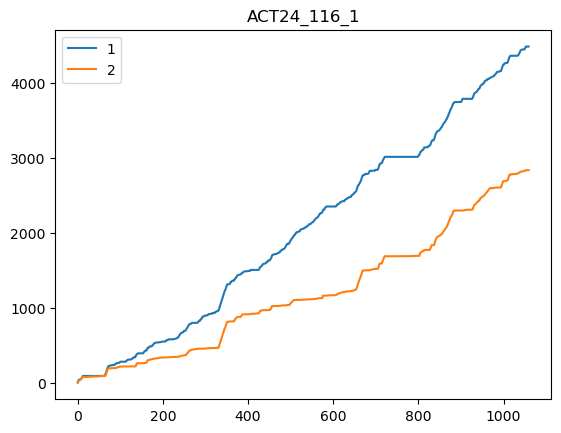

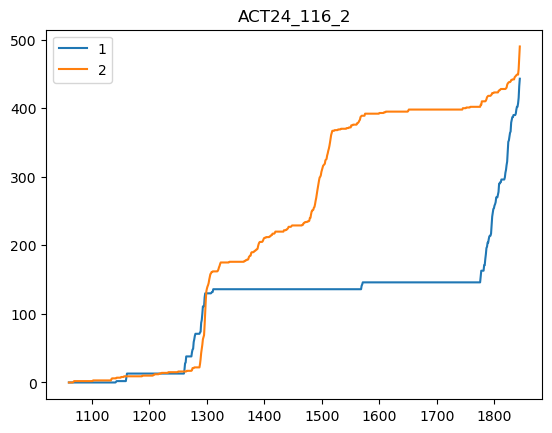

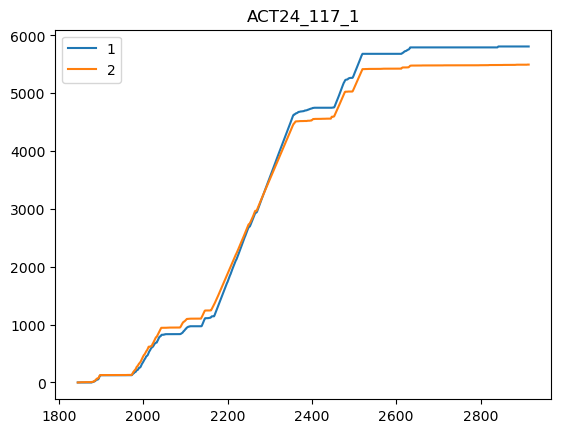

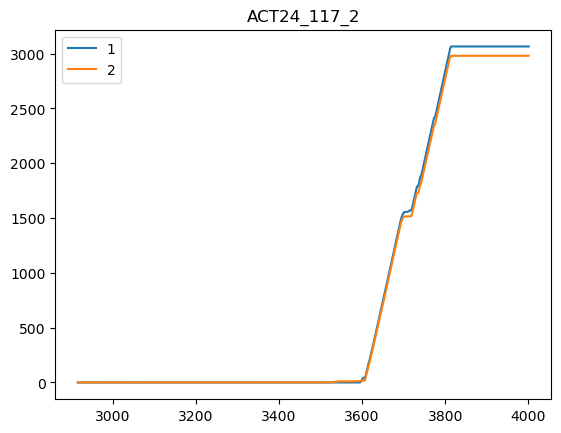

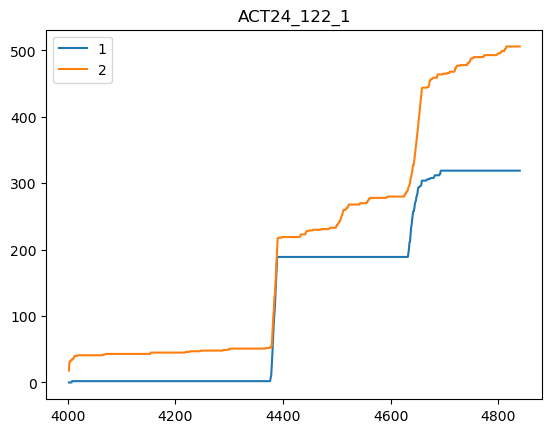

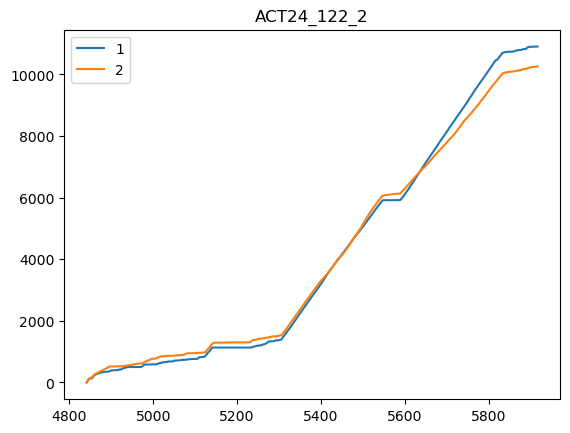

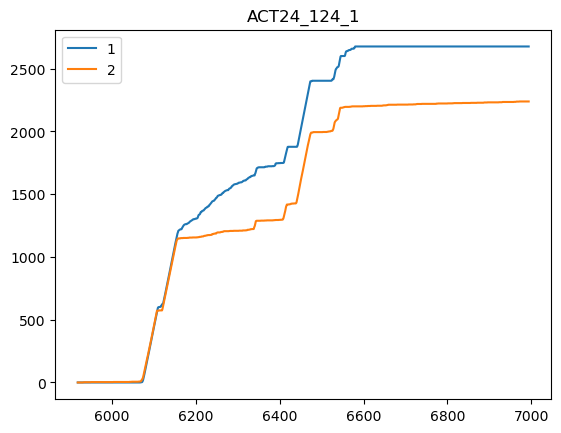

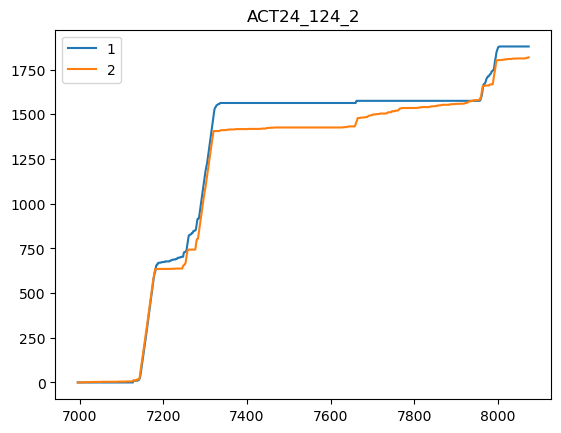

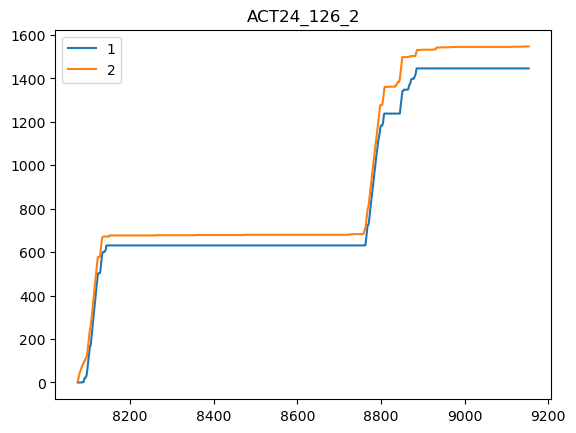

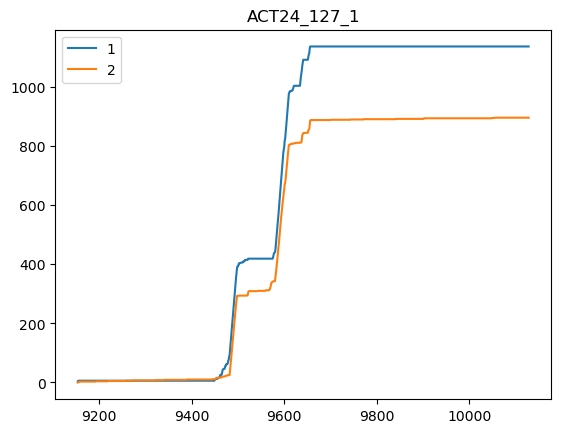

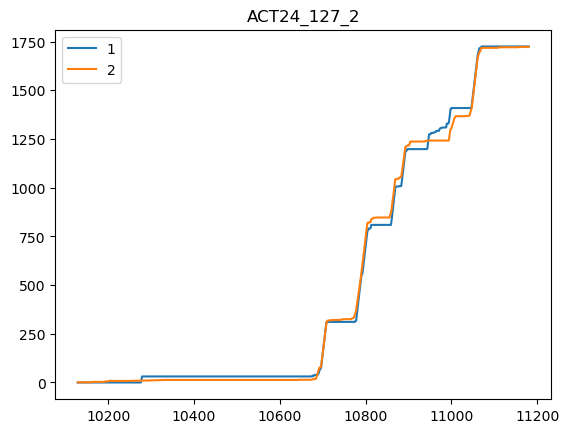

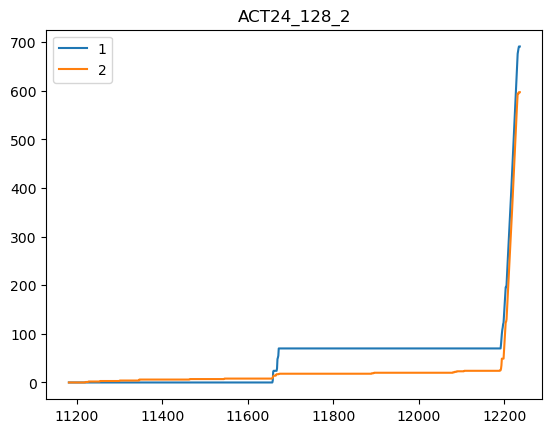

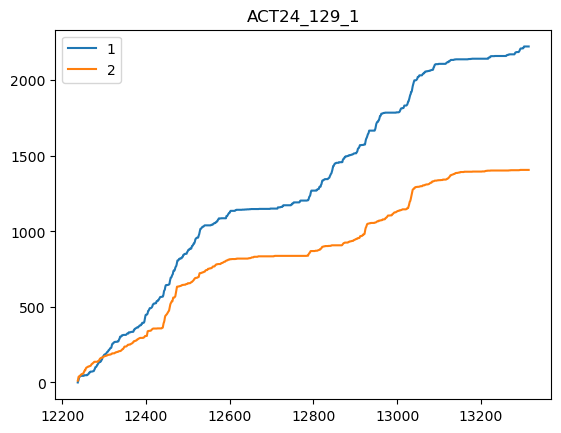

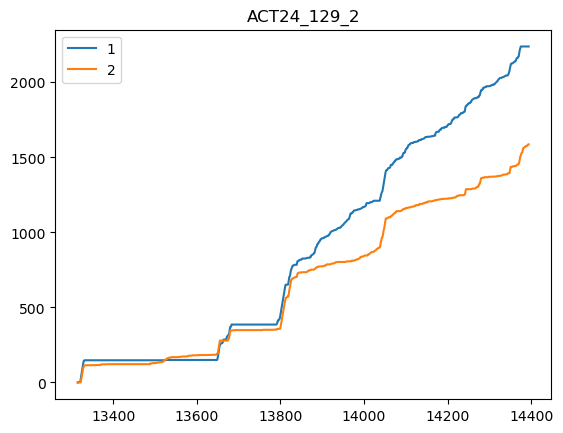

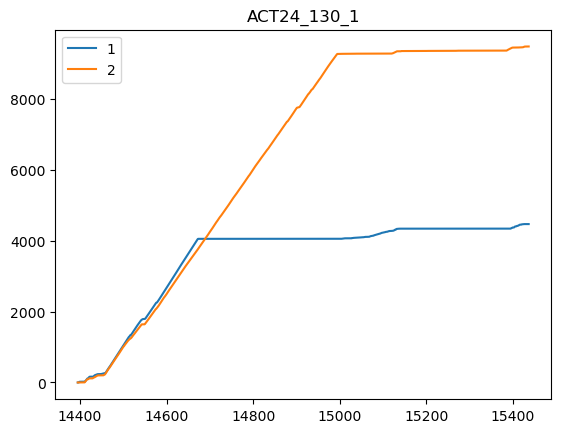

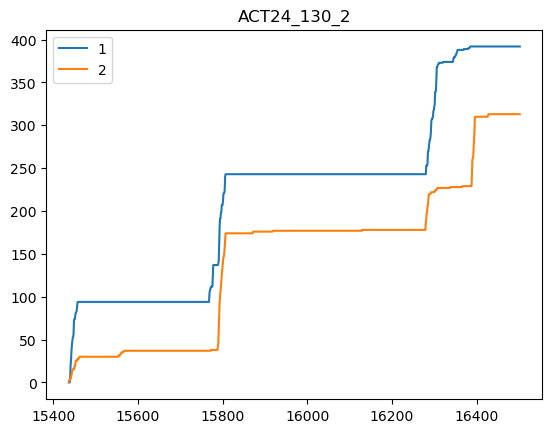

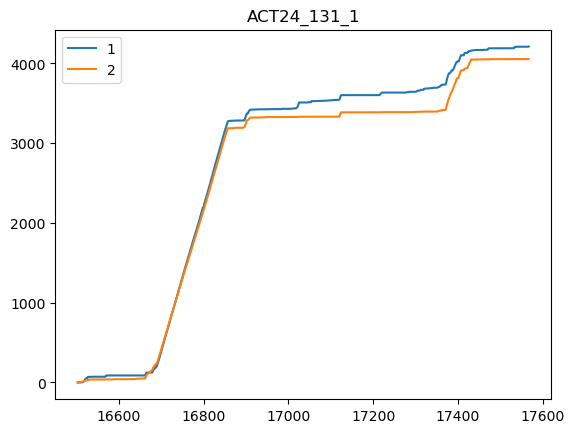

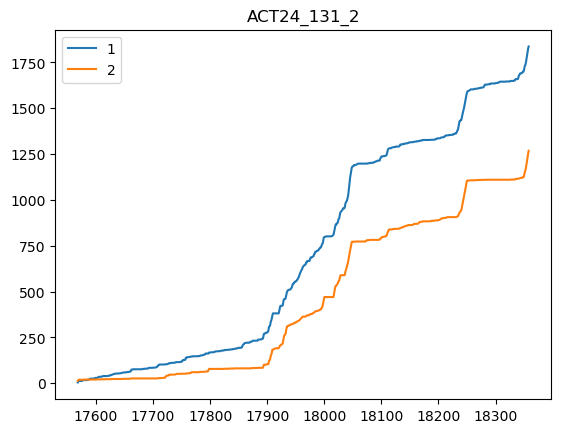

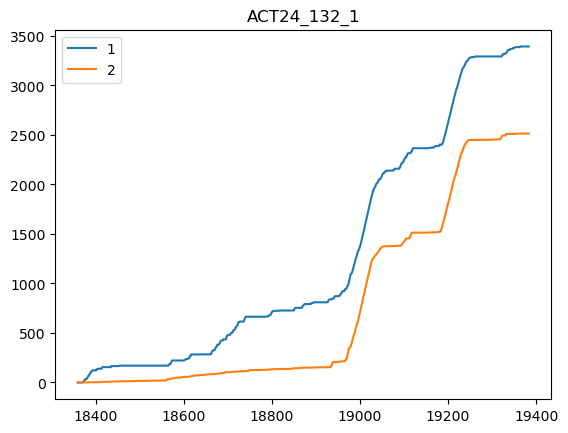

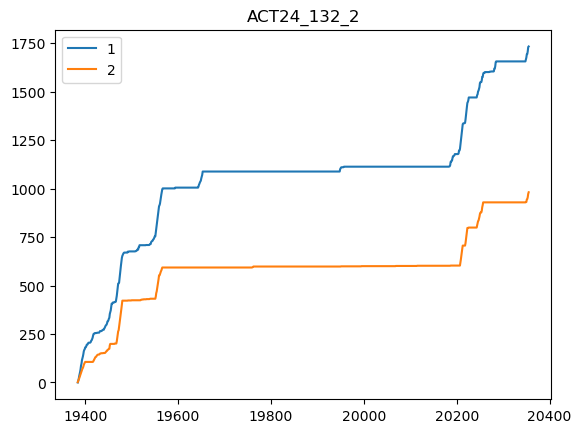

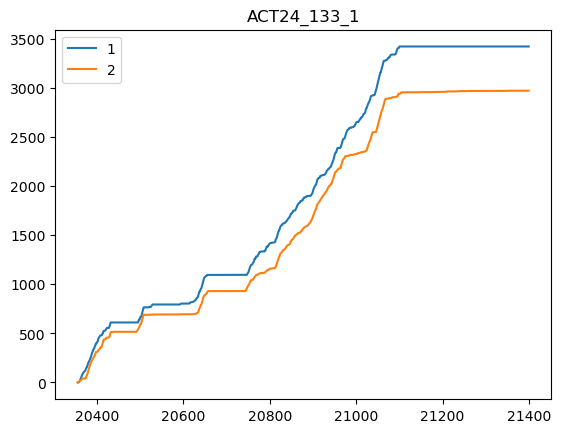

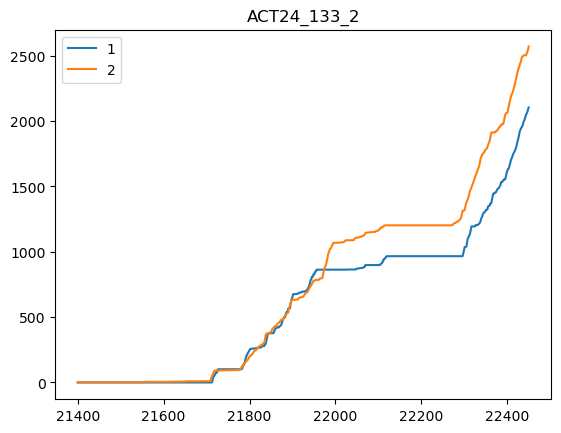

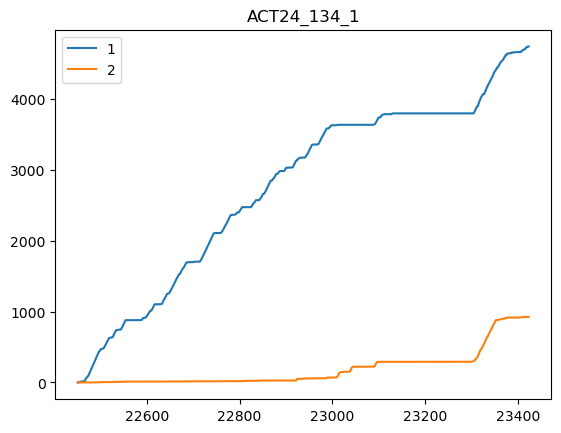

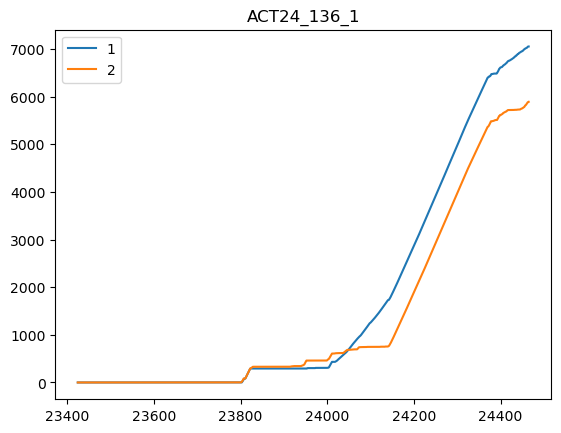

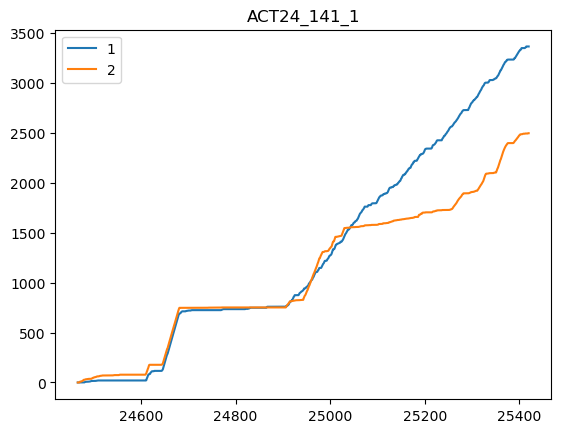

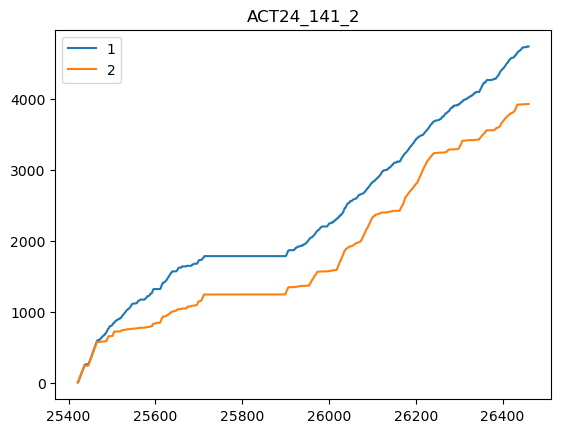

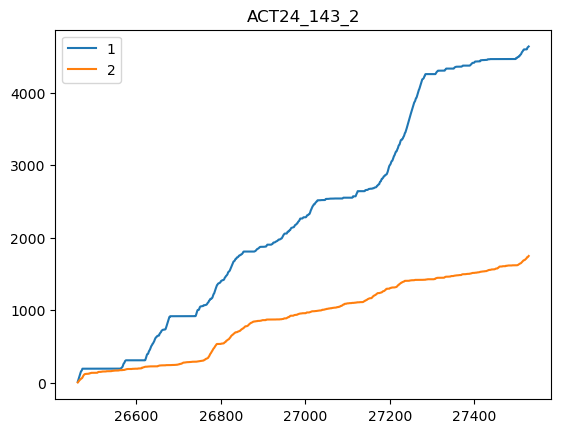

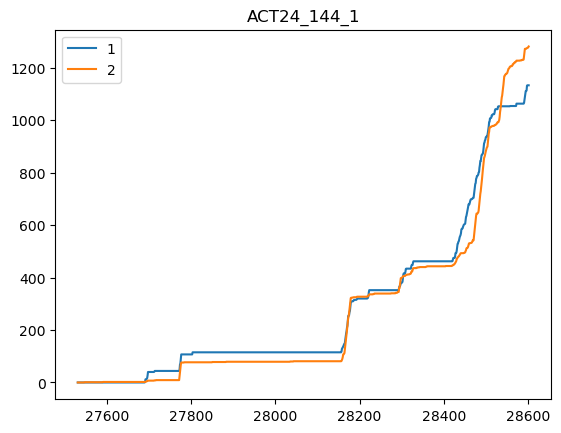

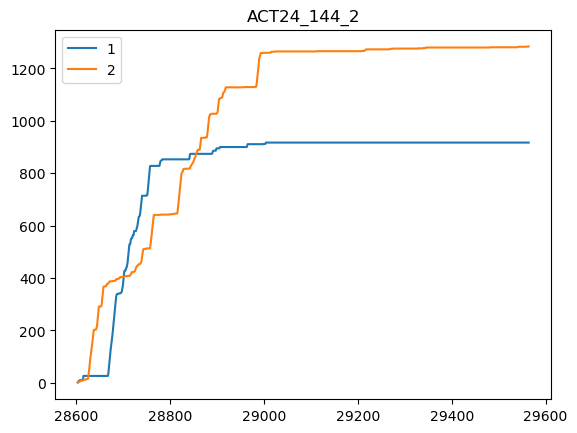

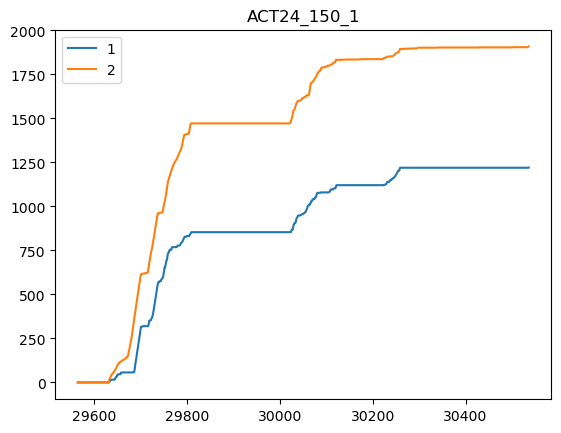

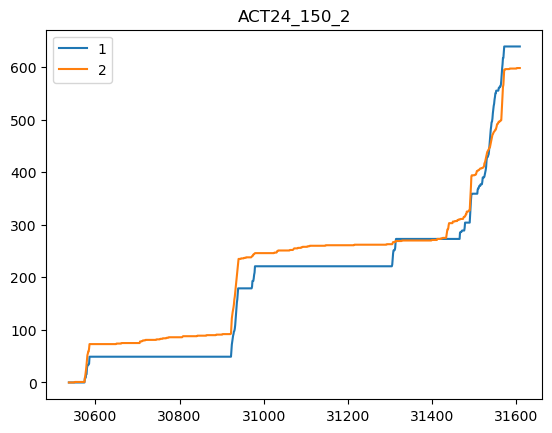

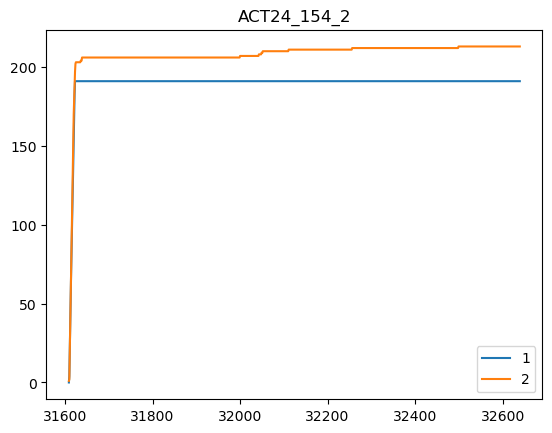

In [25]:
for g in np.unique(groups):
    preds[preds[0] == g][[1,2]].cumsum().plot.line()
    plt.title(g)
    plt.show()

Error between predicted and observed step counts, by posture:

In [27]:
Y_all = np.load(path + "Y.npy")
Y_all

array(['stand and move', 'walk', 'walk', ..., 'sitting', 'sitting',
       'sitting'], dtype='<U20')

In [28]:
pred = pd.concat([pd.Series(Y_all),
                  pd.Series(Y_step), steps_validation.reset_index(drop=True)], axis=1)
results = pred.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
ascend stairs,1993,833,1160,0.582037
bike,0,220,-220,inf
descend stairs,909,945,-36,0.039604
kneeling/ squatting,527,322,205,0.388994
lying,25,41,-16,0.640000
muscle strengthening,37,67,-30,0.810811
other sport movement,81,25,56,0.691358
running,0,5,-5,inf
sitting,2745,4079,-1334,0.485974


## Output predictions

Output predictions to .csv

In [29]:
pred_k = pd.concat([pd.Series(groups), pd.Series(T), steps_validation.reset_index(drop=True)], axis=1).rename(columns={0: "id_obs", 1: "time", 2: "pred_steps"})
pred_k

,id_obs,time,pred_steps
0,ACT24_116_1,2019-08-20 08:09:05,9
1,ACT24_116_1,2019-08-20 08:09:15,9
2,ACT24_116_1,2019-08-20 08:09:25,8
3,ACT24_116_1,2019-08-20 08:09:35,6
4,ACT24_116_1,2019-08-20 08:09:45,7
...,...,...,...
32635,ACT24_154_2,2020-02-23 15:55:09,0
32636,ACT24_154_2,2020-02-23 15:55:19,0
32637,ACT24_154_2,2020-02-23 15:55:29,0
32638,ACT24_154_2,2020-02-23 15:55:39,0


In [30]:
pred_k.to_csv("predicted_keadle_granular_loocv.csv")